# Tutorial 6 : Convolutional Latent Neural Process


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [ ]:
cd ..

In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [8]:
from utils.visualize import plot_dataset_samples_1d, plot_prior_samples_1d, plot_posterior_samples_1d, plot_losses
from ntbks_helpers import get_gp_datasets_varying # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 50000

datasets, tuple_datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model


In [9]:
from functools import partial
from neuralproc import ConvLNP
from neuralproc.utils.helpers import LightTailPareto

model = partial(ConvLNP, X_DIM, Y_DIM, is_q_zCct=True, encoded_path="latent")

In [10]:
from utils.helpers import count_parameters
print("N Param:", count_parameters(model()))

N Param: 175108


## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [11]:
from neuralproc import ELBOLossLNPF, NLLLossLNPF, SUMOLossLNPF
from utils.train import train_models
from utils.data.dataloader import cntxt_trgt_collate
from ntbks_helpers import get_cntxt_trgt

trainers = train_models(
     datasets, 
     {"ConvLNP":model},
     ELBOLossLNPF,
     chckpnt_dirname="results/notebooks/neural_process/", 
     is_retrain=True, 
     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
     patience=10,
     max_epochs=30,
    device="cuda:0",
     seed=123) 


--- Loading RBF_Kernel/ConvLNP/run_0 ---



RuntimeError: Error(s) in loading state_dict for ConvLNP:
	Missing key(s) in state_dict: "decoder.destination.weight", "decoder.destination.bias". 
	Unexpected key(s) in state_dict: "p_y_scale". 

In [ ]:
n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True, sharey=True)
if len(trainers) == 1: axes = [axes]
    
i = 0
for k, trainer in trainers.items():
    plot_losses(trainer.history, 
                title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                ax=axes[i])
    axes[i].set_ylim([-1, 1.5])
    axes[i].set_xlim([0, 100])
    i += 1

# Inference


In [15]:
EXTRAP_DISTANCE = 4  
dataset = list(datasets.values())[0]
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

## Posterior

In [16]:
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

def get_n_cntxt(n_cntxt):
    return CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=n_cntxt, max_n_indcs=n_cntxt),
                         targets_getter=get_all_indcs,
                         is_add_cntxts_to_trgts=False)

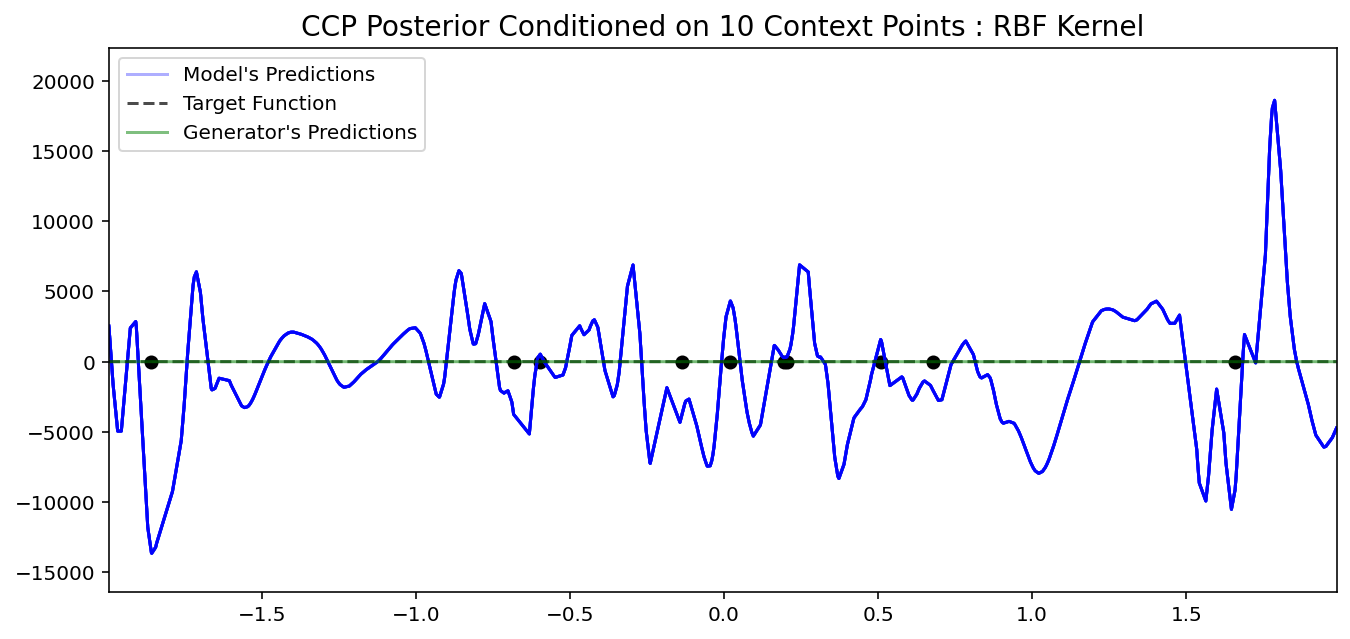

In [20]:
N_CNTXT = 10

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)
if len(trainers) == 1: axes = [axes]
    

for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]
    
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 
        
    plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainer.module_, 
                             generator=dataset.generator,
                             n_samples=10,
                             train_min_max=dataset.min_max,
                             is_plot_std=True,
                             title="CCP Posterior Conditioned on {} Context Points : {}".format(N_CNTXT, data_name.replace("_", " ")),
                             ax=axes[i])

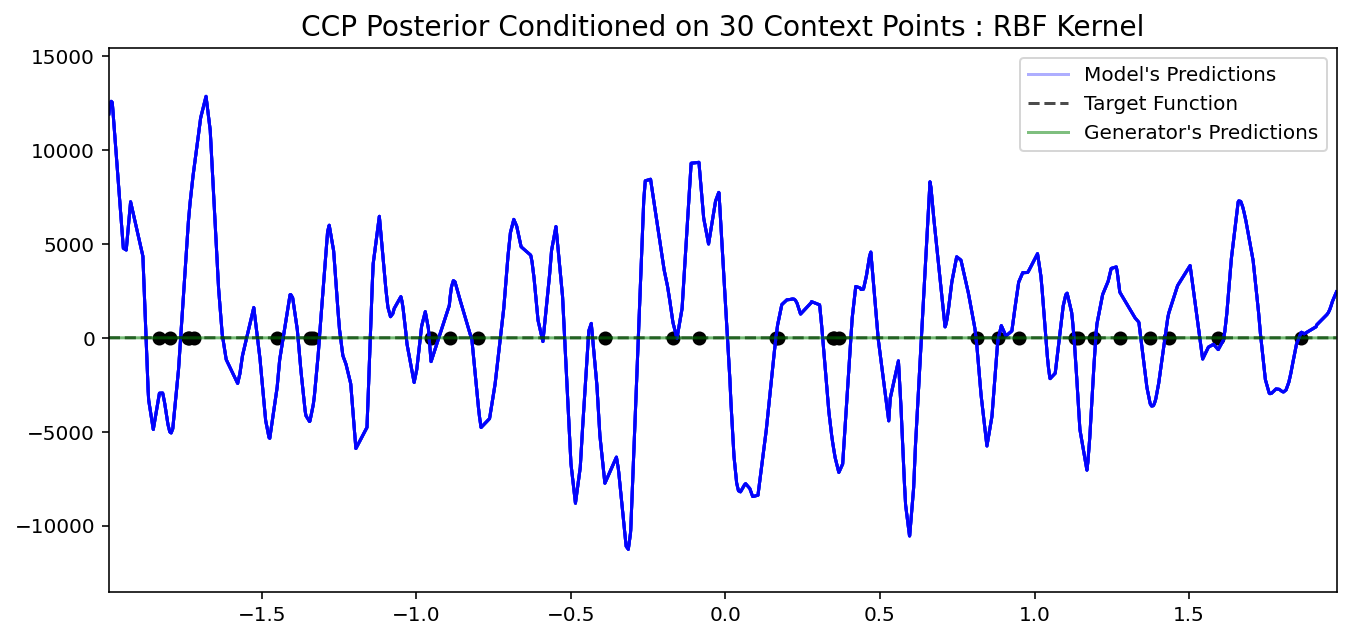

In [21]:
N_CNTXT = 30

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)
if len(trainers) == 1: axes = [axes]
    
for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]
    
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 
        
    plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainer.module_, 
                             generator=dataset.generator,
                             n_samples=10,
                             train_min_max=dataset.min_max,
                             is_plot_std=True,
                             title="CCP Posterior Conditioned on {} Context Points : {}".format(N_CNTXT, data_name.replace("_", " ")),
                             ax=axes[i])

We see that the predictions are very good

**Good**:
- the model predictions follow closely the GP (besides for periodic kernel)
- converges to good results very fast
- can extrapolate

**Bad**:
- not good at periodicity

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb

The model is translation equivariant and thus does not differentiate between the interpolation and extrapolation setting.

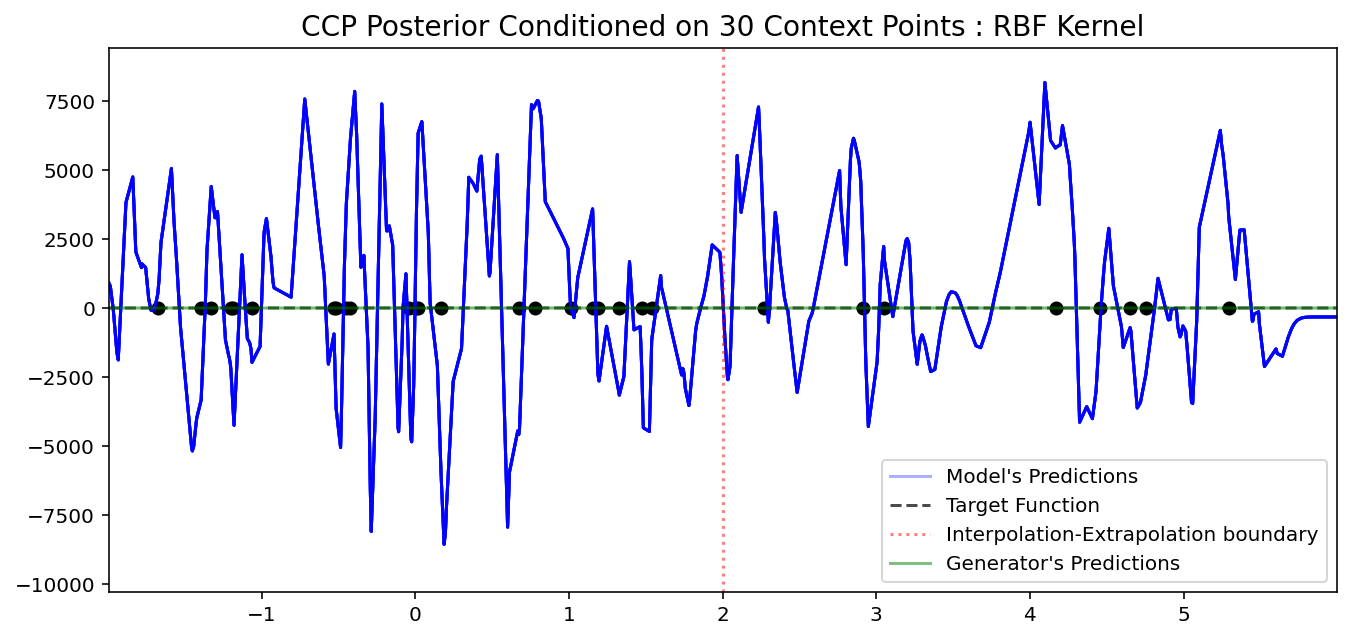

In [22]:
N_CNTXT = 30

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)
if len(trainers) == 1: axes = [axes]
    
for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]
    
    trainer.module_.set_extrapolation(EXTRAPOLATION_RANGE)
    
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS,
                               test_min_max=EXTRAPOLATION_RANGE) 
        
    plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainer.module_, 
                             generator=dataset.generator,
                             n_samples=10,
                             train_min_max=dataset.min_max,
                             is_plot_std=True,
                             title="CCP Posterior Conditioned on {} Context Points : {}".format(N_CNTXT, data_name.replace("_", " ")),
                             ax=axes[i])